In [1]:
# import python libraries needed 

import sys
import pandas as pd
import numpy as np
import scipy as sp
import IPython

# misc
import random
import time
import warnings

#disable warnings
warnings.filterwarnings('ignore')

In [2]:
#load data modeling packages

from xgboost import XGBClassifier
from sklearn import svm, linear_model, tree, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline 
mpl.style.use('ggplot')
sns.set_style('whitegrid')

In [3]:
raw_data = pd.read_csv('/PyLearning/home-data-for-ml-course/train.csv')
val_data = pd.read_csv('/PyLearning/home-data-for-ml-course/test.csv')

print(raw_data.head(5))
print('\n to the test data...')
print(val_data.head(5))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [4]:
#Check duplicates
print('\n duplicates in training set...')
print(len(raw_data[raw_data.duplicated()]))
print('\n duplicates in test set...')
print(len(val_data[val_data.duplicated()]))


 duplicates in training set...
0

 duplicates in test set...
0


In [5]:
print('\n summary infos...')
print(raw_data.info())
print(val_data.info())

#Based on the summary info, check missing values
print('\n missing value info for training set...')
print(raw_data.isnull().sum())
print('\n missing value info for test set...')
print(val_data.isnull().sum())

#Seeming like printing this way cannot show all the information...


 summary infos...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   in

In [6]:
#Writing a loop to print out all the information about missing datapoints
def print_missing_data(df):
    total_missing = df.isnull().sum()
    percent_missing = 100 * df.isnull().sum() / len(df)
    table_missing = pd.concat([total_missing, percent_missing], axis = 1)
    
    #Rename
    table_missing.columns = ['Missing Values', '% Of Total Values']
    
    #Sort 
    table_missing = table_missing[table_missing.iloc[:, 1] != 0].sort_values(by = '% Of Total Values', ascending = False).round(1)
    
    #Print summary information
    print("The dataframe passed to this function has " + str(df.shape[1]) + " columns\n and there are " + str(table_missing.shape[0]) + " columns that have missing values")
#Knowing the unique entries would also be beneficial 

In [7]:
print('\n missing value info for training set...')
print(print_missing_data(raw_data))
print('\n missing value info for test set...')
print(print_missing_data(val_data))


 missing value info for training set...
The dataframe passed to this function has 81 columns
 and there are 19 columns that have missing values
None

 missing value info for test set...
The dataframe passed to this function has 80 columns
 and there are 33 columns that have missing values
None


In [8]:
#Looking at unique values in each column is also helpful

raw_data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
val_data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         1
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        5
BldgType          5
HouseStyle        7
RoofStyle         6
RoofMatl          4
Exterior1st      13
Exterior2nd      15
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           4
HeatingQC         5
CentralAir        2
Electrical        4
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        4
GarageCond        5
PavedDrive        3
PoolQC            2
Fence             4
MiscFeature       3
SaleType          9
SaleCondition     6
dtype: int64

In [9]:
#Describe 
raw_data.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [10]:
#Deal with the Utilities Column
val_data['Utilities'].astype('string')
val_data = val_data.fillna('NAN')
val_data['Utilities'].unique()

array(['AllPub', 'NAN'], dtype=object)

In [11]:
#Encode categorical variables

#There are too many variables to transform, so we should write a function to realize this function
le = dict() #create dict label encoder object

le_count = 0

def encode_transform(app, col, le):
    #Transform both training and testing data
    app[col] = le[col].transform(app[col])
    return app, col, le

#Iterate through the columns
for col in raw_data:
    if raw_data[col].dtype == 'object':
        #for 2 or fewer unique categories
        if len(list(raw_data[col].astype('str').unique())) <= 2:
            le[col] = LabelEncoder()
            
            #Train on the training data
            le[col].fit(raw_data[col])
            encode_transform(raw_data, col, le)
            
            #Count +1
            le_count += 1
            
print('%d columns were label encoded in raw_data.' % le_count)


#Do this also for test set

le = dict() #create dict label encoder object

le_count = 0

#Iterate through the columns
for col in val_data:
    if val_data[col].dtype == 'object':
        #for 2 or fewer unique categories
        if len(list(val_data[col].astype('str').unique())) <= 2:
            le[col] = LabelEncoder()
            
            #Train on the training data
            le[col].fit(val_data[col])
            encode_transform(val_data, col, le)
            
            #Count +1
            le_count += 1
            
print('%d columns were label encoded in val_data.' % le_count)

3 columns were label encoded in raw_data.
3 columns were label encoded in val_data.


In [12]:
#Remove outliers

raw_data = raw_data.drop(raw_data[raw_data['LotArea'] > 100000].index)
raw_data = raw_data.drop(raw_data[raw_data['BsmtFinSF1'] > 4000].index)
raw_data = raw_data.drop(raw_data[raw_data['TotalBsmtSF'] > 5000].index)
raw_data = raw_data.drop(raw_data[raw_data['GrLivArea'] > 4000].index)

In [13]:
#Doing feature engineering: followed a Kaggle tutorial, go back and revisit this!
raw_data['TotalBath'] = raw_data['FullBath'] + raw_data['HalfBath']
raw_data['TotalPorch'] = raw_data['OpenPorchSF'] + raw_data['EnclosedPorch'] + raw_data['ScreenPorch']


val_data['TotalBath'] = val_data['FullBath'] + val_data['HalfBath']
val_data['TotalPorch'] = val_data['OpenPorchSF'] + val_data['EnclosedPorch'] + val_data['ScreenPorch']

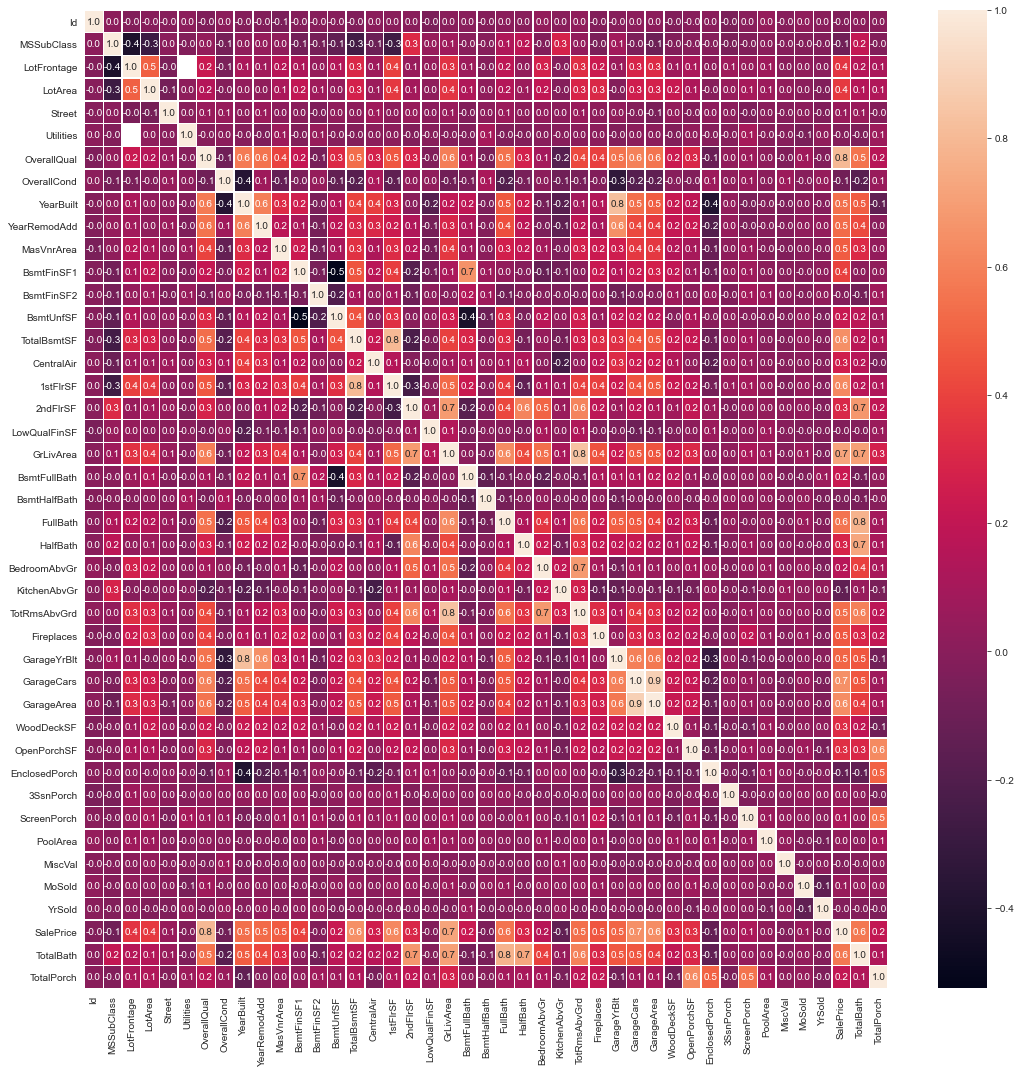

In [14]:
#Correlation map
f, ax = plt.subplots(figsize = (18, 18))
sns.heatmap(raw_data.corr(), annot = True, linewidths = 0.5, fmt = '.1f', ax = ax)
plt.show()